 # Python Practice for DMP

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from utils import (load_letter_all, split_indices, preprocess_demo, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)
# 可放在 Notebook 顶部 utils 导入下面
def normalized_jerk(pos, dt):
    """对 jerk 做路径长度与时长归一，跨数据更可比"""
    L = np.sum(np.linalg.norm(np.diff(pos, axis=1), axis=0)) + 1e-8
    T = pos.shape[1] * dt
    vel = np.gradient(pos, axis=1)/dt
    acc = np.gradient(vel, axis=1)/dt
    jerk = np.gradient(acc, axis=1)/dt
    return float(np.mean(np.linalg.norm(jerk, axis=0)) / (L * T + 1e-8))


#################################################<br>
Load and plot 2D demonstrations<br>
#################################################

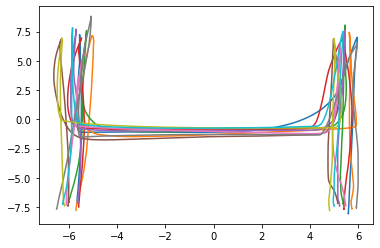

In [2]:
mat = loadmat('../2Dletters/H.mat')
demosNum = 10
dataset = []
for i in range(demosNum):
    data = mat['demos'][0, i]['pos'][0, 0]
    dataset.append(data)
    plt.plot(data[0], data[1])
plt.show()

##################################################<br>
Calculate velocity and acceleration from the position profile<br>
##################################################

In [3]:
dt = 0.005 # time interval
dim = 2   # 2D trajectory
pos = dataset[0] # only use the first demonstration for learning
tau = dt * pos.shape[1] # motion duration
vel = np.gradient(pos, axis=-1)/dt # velocity
acc = np.gradient(vel, axis=-1)/dt # acceleration
goal = pos[:, -1] # the end-point of the demonstration

#################################################<br>
Set DMP parameters and basis functions<br>
#################################################

In [4]:
kp = 150.0
kv = 25.0
alpha = 5
basis_num = 40  # number of basis functions
u = np.zeros(basis_num)
c = np.zeros(basis_num) # centers of basis functions
h = np.zeros(basis_num) # widths of basis functions
for i in range(basis_num):
    u[i] = 1.0 / basis_num * i
    c[i] = np.exp(-alpha * u[i])
for i in range(basis_num-1):
    h[i] = 0.5 / ((0.65 * (c[i+1] - c[i]))**2)
h[basis_num-1] = h[basis_num-2]

#################################################<br>
Estimate DMP pattern w<br>
#################################################

In [5]:
iterNum = int(np.round(tau / dt))
Phi = np.zeros(basis_num)
Phi_total = np.zeros((iterNum, basis_num))
force = np.zeros((iterNum, dim))

In [6]:
s = 1  # phase variable
for i in range(iterNum):
    s = -alpha * s * dt / tau + s # iteration in the canonical system
    addsum = 0
    for b in range(basis_num):
        Phi[b] = np.exp(-h[b] * (s - c[b]) ** 2)
        addsum = addsum + Phi[b]
    Phi = Phi / addsum * s
    Phi_total[i, :] = Phi
    force[i, :] = tau * tau * acc[:, i] - kp * (goal - pos[:, i]) + tau * kv * vel[:, i]

In [7]:
trainPattern = np.matmul(np.linalg.pinv(Phi_total), force)

#################################################<br>
Prediction using DMP<br>
#################################################<br>

In [8]:
# iniPos = np.array([pos[0, 0], pos[1, 0]])    # try this for reproduction
# iniVel = np.array([0, 0])                    # try this for reproduction
# newGoal = np.array([pos[0, -1], pos[1, -1]]) # try this for reproduction
# newTau = tau                                 # try this for reproduction

iniPos = np.array([pos[0, 0] - 0.5, pos[1, 0] + 0.5]) # set a new start position
iniVel = np.array([0, 0])                             # set a new start velocity
newGoal = np.array([pos[0, -1] - 1, pos[1, -1] - 1])  # set a new motion target
newTau = 2 * tau                                      # set a new motion duration

In [9]:
newLen = int(np.round(newTau / dt))
DMP_pos = np.zeros((dim, newLen))
DMP_vel = np.zeros((dim, newLen))
DMP_acc = np.zeros((dim, newLen))
s = 1 # phase variable
for i in range(newLen-1):
    s = -alpha * s * dt / newTau + s # iteration in the canonical system
    if i == 0:
        DMP_pos[:, 0] = iniPos
        DMP_vel[:, 0] = iniVel
    addsum = 0
    for b in range(basis_num):
        Phi[b] = np.exp(-h[b] * (s - c[b]) ** 2)
        addsum = addsum + Phi[b]
    newForce = np.matmul(Phi/addsum, trainPattern) * s

    # Iteration in the 2nd-order transformation system
    DMP_acc[:, i] = (kp * (newGoal - DMP_pos[:, i]) - newTau * kv * DMP_vel[:, i] + newForce) / newTau**2
    DMP_pos[:, i+1] = DMP_pos[:, i] + DMP_vel[:, i] * dt # update position using velocity
    DMP_vel[:, i+1] = DMP_vel[:, i] + DMP_acc[:, i] * dt # update velocity using acceleration

#################################################<br>
Plot predicted trajectories<br>
#################################################-

In [10]:
t0 = np.linspace(dt, tau, num=int(np.round(tau/dt)))
t = np.linspace(dt, newTau, num=int(np.round(newTau/dt)))

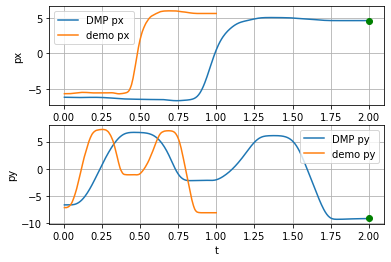

In [11]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, DMP_pos[0, :], label='DMP px')
ax1.plot(t0, pos[0, :], label='demo px')
ax1.plot(newTau, newGoal[0], 'go')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, DMP_pos[1, :], label='DMP py')
ax2.plot(t0, pos[1, :], label='demo py')
ax2.plot(newTau, newGoal[1], 'go')
ax2.set_xlabel("t")
ax2.set_ylabel("py")
plt.legend()
ax2.grid()
plt.show()

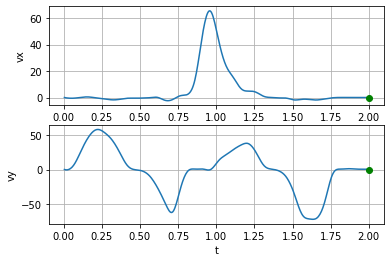

In [12]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, DMP_vel[0, :])
ax1.plot(newTau, 0, 'go')
ax1.set_ylabel("vx")
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, DMP_vel[1, :])
ax2.plot(newTau, 0, 'go')
ax2.set_xlabel("t")
ax2.set_ylabel("vy")
ax2.grid()
plt.show()

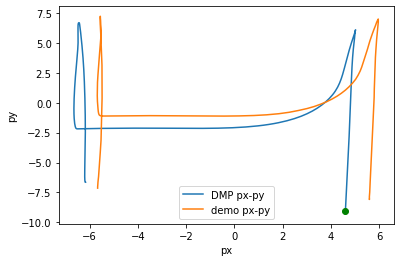

In [13]:
plt.plot(DMP_pos[0, :], DMP_pos[1, :], label='DMP px-py')    # DMP trajectory
plt.plot(pos[0, :], pos[1, :], label='demo px-py')      # demonstration
plt.plot(newGoal[0], newGoal[1], 'go')
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

In [14]:
goalErr = DMP_pos[0:2, -1] - newGoal
velErr = DMP_vel[0:2, -1]
print("DMP target error:", goalErr)
print("DMP velocity error:", velErr)

DMP target error: [ 0.0003731  -0.07258282]
DMP velocity error: [-0.00090208  0.42294973]


In [12]:
# 配置
letters = ['A','B','G','H']
T = 200
save_csv = 'results/reproduction.csv'
csv_header = ['method','letter','demo','rmse','end_err','jerk','train_ms','infer_ms']

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')  # 统一预处理
    for demo_idx, prep in enumerate(preps):
        pos, vel, acc, dt = prep['pos'], prep['vel'], prep['acc'], prep['dt']
        # === 你的DMP学习 ===
        with timer() as t_train:
            # 逐维学习强迫项（用你自己的代码/函数）
            ws = []  # 假设学到每维的权重
            # ...
        train_ms = t_train()

        with timer() as t_infer:
            # rollout 得到 y_repro: (2,T)
            y_repro = np.zeros_like(pos)
            # ...
        infer_ms = t_infer()

        # 反归一化 & 评估
        y_pred = denormalize(y_repro, prep['stats'])
        y_true = denormalize(pos,       prep['stats'])
        m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, dt)

        append_csv(save_csv, csv_header, ['DMP', letter, demo_idx, m, e, j, train_ms, infer_ms])
        print(letter, demo_idx, 'RMSE=', m, 'end=', e, 'jerk=', j)


A 0 RMSE= 4.146529326952713 end= 3.836394701628826 jerk= 0.0
A 1 RMSE= 3.8559649197290042 end= 4.925380787360648 jerk= 0.0
A 2 RMSE= 3.943467308766417 end= 3.8970124972589404 jerk= 0.0
A 3 RMSE= 3.8228270455185527 end= 4.283507624356631 jerk= 0.0
A 4 RMSE= 3.711385371358485 end= 4.13896978076202 jerk= 0.0
A 5 RMSE= 3.497581349893156 end= 4.068142705078669 jerk= 0.0
A 6 RMSE= 3.7545817790948846 end= 4.431045816992077 jerk= 0.0
A 7 RMSE= 3.49783768076619 end= 3.945063346109533 jerk= 0.0
A 8 RMSE= 3.721761174835709 end= 3.3886728275451814 jerk= 0.0
A 9 RMSE= 3.8901215824941127 end= 5.548915679976003 jerk= 0.0
B 0 RMSE= 5.30931543533 end= 7.588555234133274 jerk= 0.0
B 1 RMSE= 5.408034683645346 end= 7.899980790857417 jerk= 0.0
B 2 RMSE= 5.585287620189723 end= 8.177499813679297 jerk= 0.0
B 3 RMSE= 5.526499804282001 end= 8.25681712386902 jerk= 0.0
B 4 RMSE= 5.412792236353688 end= 8.436748172757982 jerk= 0.0
B 5 RMSE= 5.647059079772834 end= 8.2857664279339 jerk= 0.0
B 6 RMSE= 5.660333999908358

In [18]:
save_csv = 'results/reproduction.csv'


In [20]:
# ===== LOO Cross-Validation for DMP (paste & run) =====

import numpy as np

# ---- DMP helpers ----
def dmp_make_basis(n_basis=20):
    centers = np.linspace(0, 1, n_basis)
    widths  = np.ones(n_basis) * (n_basis**2)
    def psi(phase_01):                         # phase_01: shape (T,) in [0,1]
        X = phase_01.reshape(1, -1)            # (1,T)
        C = centers.reshape(-1, 1)             # (B,1)
        return np.exp(-widths.reshape(-1,1) * (X - C)**2)   # (B,T)
    return psi

def dmp_learn_w_multi(preps_train, alpha_z=25.0, beta_z=25.0/4.0, n_basis=20):
    """
    从多条演示联合学习每个维度的强迫项权重 w。
    所有演示在预处理后 T 相同；Phi 共享；按 demo 叠加最小二乘。
    返回 ws: (D=2, B)
    """
    T = preps_train[0]['pos'].shape[1]
    psi = dmp_make_basis(n_basis)
    phase = np.linspace(0, 1, T)
    Psi = psi(phase)                                      # (B,T)
    Phi_TN = (Psi / (Psi.sum(axis=0, keepdims=True)+1e-8)).T  # (T,B)

    ws = []
    for d in range(2):                                     # x / y 维度分别学
        # 堆叠所有训练演示
        big_Phi = []
        big_f   = []
        for p in preps_train:
            pos = p['pos'][d]                              # (T,)
            vel = p['vel'][d]
            acc = p['acc'][d]
            dt  = p['dt']
            tau = p['t'][-1] - p['t'][0]

            f_target = (tau**2) * acc + alpha_z*(beta_z*(pos[-1] - pos) - tau*vel)  # (T,)
            big_Phi.append(Phi_TN)                         # (T,B)
            big_f.append(f_target.reshape(-1,1))          # (T,1)

        big_Phi = np.vstack(big_Phi)                      # (T*H, B)
        big_f   = np.vstack(big_f).reshape(-1)            # (T*H,)

        # 最小二乘求解
        w, *_ = np.linalg.lstsq(big_Phi, big_f, rcond=None)
        ws.append(w)
    return np.stack(ws, axis=0)                            # (2, B)

def dmp_rollout(y0, g, dt, T, w_d, alpha_z=25.0, beta_z=25.0/4.0):
    """ 单维 DMP rollout，返回 y: (T,) """
    tau = dt*(T-1)
    psi = dmp_make_basis(len(w_d))
    phase = np.linspace(0, 1, T)

    y  = np.zeros(T); dy = np.zeros(T); ddy = np.zeros(T)
    y[0] = y0
    for t in range(T-1):
        Psi = psi(np.array([phase[t]]))[:,0]               # (B,)
        f   = (Psi / (Psi.sum()+1e-8)).dot(w_d)
        ddy[t] = (alpha_z*(beta_z*(g - y[t]) - tau*dy[t]) + f) / (tau**2)
        dy[t+1] = dy[t] + ddy[t]*dt
        y[t+1]  = y[t]  + dy[t+1]*dt
    return y

# ---- LOO driver ----
letters = ['A','B','G','H']
T = 200
save_csv = 'results/reproduction_LOO.csv'
csv_header = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']

for letter in letters:
    # 统一预处理加载该字母的所有演示
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[{letter}] demos = {N}')

    for fold in range(N):                      # 留一：每次留出一条作为测试
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # === 训练：多演示联合学习 w ===
        with timer() as t_train:
            ws = dmp_learn_w_multi(preps_tr, alpha_z=25.0, beta_z=25.0/4.0, n_basis=20)  # (2,B)
        train_ms = t_train()

        # === 预测：在测试演示的起止条件下 rollout ===
        with timer() as t_infer:
            pos_te = prep_te['pos']                             # (2,T)
            dt     = prep_te['dt']; T_te = pos_te.shape[1]
            y0 = pos_te[:,0]; g = pos_te[:,-1]

            y_pred_n = np.zeros_like(pos_te)                    # 归一化空间中的预测
            for d in range(2):
                y_pred_n[d] = dmp_rollout(y0[d], g[d], dt, T_te, ws[d],
                                           alpha_z=25.0, beta_z=25.0/4.0)
        infer_ms = t_infer()

        # === 反归一化 + 评估 ===
        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred)
        e = endpoint_err(y_true, y_pred)
        j = jerk_score(y_pred, dt)

        append_csv(save_csv, csv_header, ['DMP', letter, fold, m, e, j, train_ms, infer_ms])
        print(f'[{letter}] fold={fold}  RMSE={m:.6f}  end={e:.6f}  jerk={j:.6f}  train={train_ms:.1f}ms infer={infer_ms:.1f}ms')

[A] demos = 10
[A] fold=0  RMSE=8.876451  end=1.653413  jerk=39379.835138  train=16.4ms infer=6.6ms
[A] fold=1  RMSE=8.507886  end=1.461470  jerk=31912.254994  train=1.3ms infer=8.7ms
[A] fold=2  RMSE=8.518849  end=1.485465  jerk=32006.590186  train=1.9ms infer=8.1ms
[A] fold=3  RMSE=8.325539  end=1.493797  jerk=31599.385889  train=1.2ms infer=6.0ms
[A] fold=4  RMSE=8.109058  end=1.420237  jerk=30945.738488  train=1.1ms infer=6.8ms
[A] fold=5  RMSE=7.620884  end=1.350727  jerk=28607.585106  train=1.2ms infer=6.1ms
[A] fold=6  RMSE=8.055003  end=1.484050  jerk=31001.982219  train=1.4ms infer=7.5ms
[A] fold=7  RMSE=7.156890  end=1.327858  jerk=31713.941272  train=1.8ms infer=6.9ms
[A] fold=8  RMSE=7.790793  end=1.460617  jerk=31480.348599  train=1.7ms infer=8.7ms
[A] fold=9  RMSE=8.618459  end=1.533965  jerk=32501.100505  train=1.4ms infer=8.2ms
[B] demos = 12
[B] fold=0  RMSE=16.139550  end=2.248122  jerk=36075.230328  train=2.6ms infer=5.8ms
[B] fold=1  RMSE=16.633441  end=2.329761  je

In [24]:
# ===== DMP Goal-Change under LOO (paste & run) =====
# 在每一折上，把测试演示的目标点 g 沿 x 方向平移（相当于新任务目标），观察 DMP 的适应能力
# 结果保存到 results/goal_change.csv，并可选输出对照图到 figs/

import os
import numpy as np
import matplotlib.pyplot as plt
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

# 若你用了 normalized_jerk，请把这一行替换为：from __main__ import normalized_jerk
jerk_func = jerk_score   # 或者 normalized_jerk

# 你 LOO 训练时用到的函数（和前面一致）
def dmp_make_basis(n_basis=20):
    centers = np.linspace(0, 1, n_basis)
    widths  = np.ones(n_basis) * (n_basis**2)
    def psi(phase_01):
        X = phase_01.reshape(1, -1)
        C = centers.reshape(-1, 1)
        return np.exp(-widths.reshape(-1,1) * (X - C)**2)
    return psi

def dmp_learn_w_multi(preps_train, alpha_z=25.0, beta_z=25.0/4.0, n_basis=20):
    T = preps_train[0]['pos'].shape[1]
    psi = dmp_make_basis(n_basis)
    phase = np.linspace(0, 1, T)
    Psi = psi(phase)
    Phi_TN = (Psi / (Psi.sum(axis=0, keepdims=True)+1e-8)).T

    ws = []
    for d in range(2):
        big_Phi = []
        big_f   = []
        for p in preps_train:
            pos = p['pos'][d]; vel = p['vel'][d]; acc = p['acc'][d]
            tau = p['t'][-1] - p['t'][0]
            f_target = (tau**2) * acc + alpha_z*(beta_z*(pos[-1] - pos) - tau*vel)
            big_Phi.append(Phi_TN)
            big_f.append(f_target.reshape(-1,1))
        big_Phi = np.vstack(big_Phi)
        big_f   = np.vstack(big_f).reshape(-1)
        w, *_ = np.linalg.lstsq(big_Phi, big_f, rcond=None)
        ws.append(w)
    return np.stack(ws, axis=0)

def dmp_rollout(y0, g, dt, T, w_d, alpha_z=25.0, beta_z=25.0/4.0):
    tau = dt*(T-1)
    psi = dmp_make_basis(len(w_d))
    phase = np.linspace(0, 1, T)
    y  = np.zeros(T); dy = np.zeros(T); ddy = np.zeros(T)
    y[0] = y0
    for t in range(T-1):
        Psi = psi(np.array([phase[t]]))[:,0]
        f   = (Psi / (Psi.sum()+1e-8)).dot(w_d)
        ddy[t] = (alpha_z*(beta_z*(g - y[t]) - tau*dy[t]) + f) / (tau**2)
        dy[t+1] = dy[t] + ddy[t]*dt
        y[t+1]  = y[t]  + dy[t+1]*dt
    return y

# ---------- 参数 ----------
letters   = ['A','B','G','H']
T         = 200
n_basis   = 20
alpha_z   = 25.0
beta_z    = 25.0/4.0
shift_ratios = [0.2]   # 目标平移比例（相对于字母宽度）；可加 [0.1,0.2,0.3] 多档
os.makedirs('figs', exist_ok=True)

save_csv = 'results/goal_change.csv'
csv_header = ['method','letter','fold','shift_ratio','rmse','end_err_to_new_goal','jerk','train_ms','infer_ms']

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[GoalChange] {letter}: demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # —— 训练权重（与复现一致）——
        with timer() as t_train:
            ws = dmp_learn_w_multi(preps_tr, alpha_z=alpha_z, beta_z=beta_z, n_basis=n_basis)
        train_ms = t_train()

        # —— 测试 demo 的归一化起点/终点/时长 —— 
        pos_n = prep_te['pos']; dt = prep_te['dt']; T_te = pos_n.shape[1]
        y0_n  = pos_n[:, 0]  # 起点（归一化）
        g_n   = pos_n[:, -1] # 原目标（归一化）

        # —— 反归一化得到真实轨迹，方便计算“字母宽度”和新目标 —— 
        y_true = denormalize(pos_n, prep_te['stats'])
        width  = float(y_true[0].max() - y_true[0].min()) + 1e-8   # x 方向宽度
        g_den  = y_true[:, -1]                                     # 原目标（非归一化）

        for r in shift_ratios:
            # 1) 设定新目标（非归一化空间）
            g_new_den = g_den + np.array([r*width, 0.0])           # x 正向平移 r*width

            # 2) 把新目标映射回归一化空间（用于 DMP rollout）
            mean = prep_te['stats']['mean']; std = prep_te['stats']['std']
            g_new_n = (g_new_den.reshape(-1,1) - mean) / std
            g_new_n = g_new_n.reshape(-1)

            # 3) rollout 到新目标
            with timer() as t_infer:
                y_pred_n = np.zeros_like(pos_n)
                for d in range(2):
                    y_pred_n[d] = dmp_rollout(y0_n[d], g_new_n[d], dt, T_te, ws[d],
                                              alpha_z=alpha_z, beta_z=beta_z)
            infer_ms = t_infer()

            # 4) 反归一化 & 评估（注意终点误差要对新目标）
            y_pred = denormalize(y_pred_n, prep_te['stats'])
            m = rmse(y_true, y_pred)
            e = float(np.linalg.norm(g_new_den - y_pred[:, -1]))   # 对新目标的终点误差
            j = jerk_func(y_pred, dt)

            append_csv(save_csv, csv_header,
                       ['DMP', letter, fold, r, m, e, j, train_ms, infer_ms])

            # 5) 画一张对照图（可选）
            fig_path = f'figs/dmp_goalchange_{letter}_fold{fold}_r{r}.png'
            plt.figure(figsize=(4.2,4.2))
            plt.plot(y_true[0], y_true[1], 'k--', lw=1, label='GT')
            plt.plot(y_pred[0], y_pred[1], 'b-', lw=2, label='DMP@new goal')
            plt.scatter([g_den[0]],[g_den[1]], c='gray', s=40, label='old goal')
            plt.scatter([g_new_den[0]],[g_new_den[1]], c='r', s=40, label='new goal')
            plt.gca().set_aspect('equal'); plt.title(f'{letter} fold{fold} shift={r}')
            plt.legend(frameon=False); plt.tight_layout(); plt.savefig(fig_path, dpi=200); plt.close()

            print(f'  fold={fold} r={r:.2f}  RMSE={m:.3f}  end->new={e:.3f}  jerk={j:.3f}  '
                  f'train={train_ms:.1f}ms infer={infer_ms:.1f}ms')

print('Goal-change finished. CSV ->', save_csv)


[GoalChange] A: demos=10
  fold=0 r=0.20  RMSE=9.608  end->new=1.654  jerk=39757.232  train=1.9ms infer=10.9ms
  fold=1 r=0.20  RMSE=9.372  end->new=1.462  jerk=32308.240  train=1.8ms infer=6.0ms
  fold=2 r=0.20  RMSE=9.302  end->new=1.486  jerk=32402.798  train=2.0ms infer=6.8ms
  fold=3 r=0.20  RMSE=9.133  end->new=1.494  jerk=31984.079  train=2.4ms infer=10.2ms
  fold=4 r=0.20  RMSE=8.912  end->new=1.421  jerk=31328.722  train=2.1ms infer=9.1ms
  fold=5 r=0.20  RMSE=8.417  end->new=1.351  jerk=28981.373  train=1.7ms infer=6.1ms
  fold=6 r=0.20  RMSE=8.902  end->new=1.484  jerk=31395.666  train=1.8ms infer=8.5ms
  fold=7 r=0.20  RMSE=7.940  end->new=1.328  jerk=32070.727  train=2.1ms infer=6.0ms
  fold=8 r=0.20  RMSE=8.594  end->new=1.461  jerk=31888.536  train=1.6ms infer=6.1ms
  fold=9 r=0.20  RMSE=9.602  end->new=1.534  jerk=32926.557  train=1.9ms infer=6.4ms
[GoalChange] B: demos=12
  fold=0 r=0.20  RMSE=15.581  end->new=2.248  jerk=36210.779  train=1.4ms infer=6.2ms
  fold=1 r=0

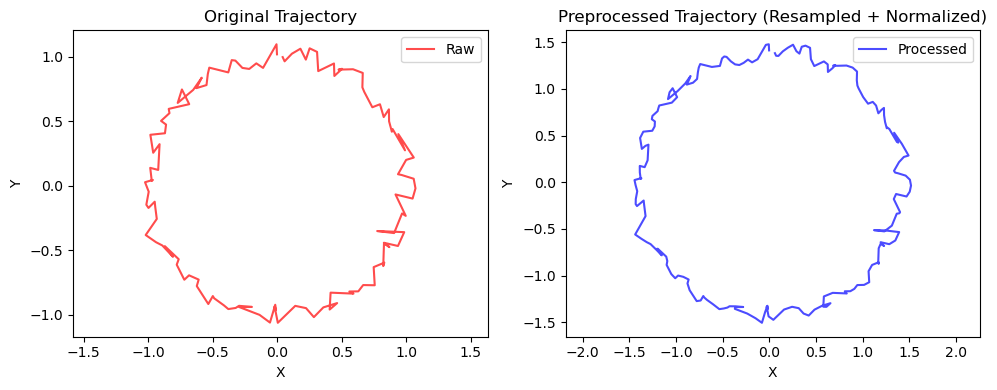

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 1. 模拟读取原始轨迹 =====
# 假设原始轨迹是 (N,2) 的坐标点
# 这里用一个模拟的弯曲轨迹代替，你换成 np.loadtxt 或 pd.read_csv 即可
t = np.linspace(0, 1, 120)   # 原始轨迹点数 = 120
x = np.sin(2 * np.pi * t) + 0.05 * np.random.randn(len(t))  # 带噪声
y = np.cos(2 * np.pi * t) + 0.05 * np.random.randn(len(t))
raw_traj = np.vstack([x, y]).T

# ===== 2. 预处理：重采样 + 标准化 =====
T = 200  # 统一长度
t_new = np.linspace(0, 1, T)
x_resampled = np.interp(t_new, np.linspace(0,1,len(x)), x)
y_resampled = np.interp(t_new, np.linspace(0,1,len(y)), y)
traj_resampled = np.vstack([x_resampled, y_resampled]).T

# 标准化（零均值 + 单位方差）
mean = traj_resampled.mean(axis=0)
std = traj_resampled.std(axis=0)
traj_norm = (traj_resampled - mean) / std

# ===== 3. 绘制对比图 =====
plt.figure(figsize=(10,4))

# 原始轨迹
plt.subplot(1,2,1)
plt.plot(raw_traj[:,0], raw_traj[:,1], 'r-', alpha=0.7, label='Raw')
plt.title("Original Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")

# 预处理后轨迹
plt.subplot(1,2,2)
plt.plot(traj_norm[:,0], traj_norm[:,1], 'b-', alpha=0.7, label='Processed')
plt.title("Preprocessed Trajectory (Resampled + Normalized)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")

plt.tight_layout()
plt.show()
